https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
import numpy as np
import sys
import os
import PIL
import tensorflow as tf
from keras import callbacks
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_dir = sys.argv[1]
val_dir = sys.argv[2]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,image_size=(224,224))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,image_size=(224,224))



Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  #tf.keras.layers.experimental.preprocessing.RandomCrop(224,224),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

(32, 7, 7, 1280)


In [ ]:
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)



(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))



1/1 [==============================] - 7s 7s/step - loss: 0.8190 - accuracy: 0.3750
initial loss: 0.82
initial accuracy: 0.38


In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks =[earlystopping])


Epoch 1/10
163/163 [==============================] - 1564s 10s/step - loss: 0.5232 - accuracy: 0.7071 - val_loss: 0.7698 - val_accuracy: 0.5625
Epoch 2/10
111/163 [===================>..........] - ETA: 1:38 - loss: 0.4107 - accuracy: 0.8063

KeyboardInterrupt: ignored

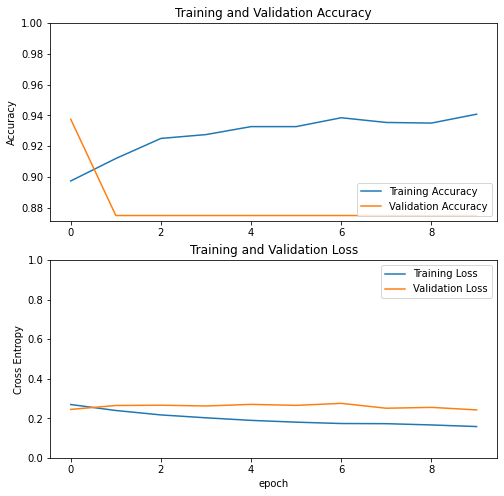

In [ ]:
# import matplotlib.pyplot as plt
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()


In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])


Number of layers in the base model:  154


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)
model.save('save/one')

Epoch 10/20
163/163 [==============================] - 434s 3s/step - loss: 0.1574 - accuracy: 0.9363 - val_loss: 0.0880 - val_accuracy: 1.0000
Epoch 11/20
163/163 [==============================] - 428s 3s/step - loss: 0.1173 - accuracy: 0.9535 - val_loss: 0.3992 - val_accuracy: 0.8125
Epoch 12/20
163/163 [==============================] - 428s 3s/step - loss: 0.0958 - accuracy: 0.9617 - val_loss: 0.1355 - val_accuracy: 0.9375
Epoch 13/20
163/163 [==============================] - 430s 3s/step - loss: 0.0896 - accuracy: 0.9615 - val_loss: 0.1932 - val_accuracy: 0.8750
Epoch 14/20
163/163 [==============================] - 429s 3s/step - loss: 0.0807 - accuracy: 0.9672 - val_loss: 0.0368 - val_accuracy: 1.0000
Epoch 15/20
163/163 [==============================] - 430s 3s/step - loss: 0.0787 - accuracy: 0.9666 - val_loss: 0.0910 - val_accuracy: 1.0000
Epoch 16/20
163/163 [==============================] - 430s 3s/step - loss: 0.0656 - accuracy: 0.9725 - val_loss: 0.2074 - val_accuracy: